# Rothko WGAN-GP

The code has been adapted from the excellent [WGAN-GP tutorial](https://keras.io/examples/generative/wgan_gp_) created by Aakash Kumar Nain, available on the Keras website.

In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
    
)
# import keras_cv

from notebooks.utils import display, display_rows, sample_batch, normalize_image_data, denormalize_image_data
from notebooks.classes.WGANGP import WGANGP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
with tf.device('/gpu:0'):
    print(tf.config.list_physical_devices())
    gpu = tf.config.list_physical_devices("GPU")
    if not gpu:
        raise

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 0. Parameters <a name="parameters"></a>

In [9]:
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 1000
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [10]:
# Data augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        # keras_cv.layers.preprocessing.RandomHue(),
    ]
)

## 1. Prepare the data <a name="prepare"></a>

In [11]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/app/images/rothko/raw/",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)


#train_data = train_data.map(lambda x: (data_augmentation(x)))


train = train_data.map(lambda x: normalize_image_data(x))

Found 99 files belonging to 1 classes.


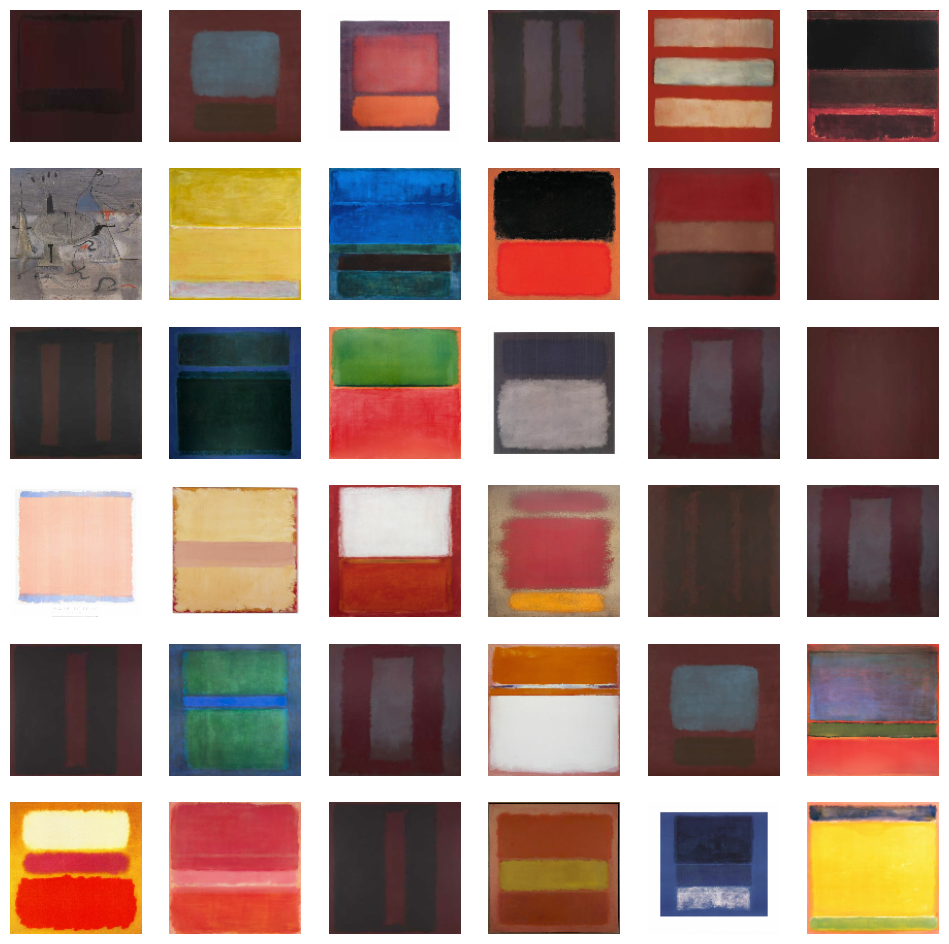

In [12]:
train_sample = sample_batch(train)
display_rows(train_sample, cmap=None, r=6, c=6)

## 2. Build the WGAN-GP <a name="build"></a>

In [13]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(IMAGE_SIZE, kernel_size=4, strides=4, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1024, kernel_size=4, strides=1, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       6272      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [14]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(
    512, kernel_size=3, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(
    256, kernel_size=3, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(
    128, kernel_size=3, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=1, padding="same", use_bias=False
)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=4, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        1048576   
 nspose)                                                         
                                                                 
 dropout_4 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 512)         2359296   
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                             

In [15]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [16]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/wgan_gp_checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [17]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [18]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/wgan_gp_checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/wgan_gp_generated_img_%03d.png" % (epoch),
                cmap=None,
            )

In [ ]:
wgangp.fit(
    train.repeat(),
    epochs=EPOCHS,
    steps_per_epoch=2,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [20]:
# Save the final models
generator.save("./models/wgan_gp_generator")
critic.save("./models/wgan_gp_critic")

INFO:tensorflow:Assets written to: ./models/wgan_gp_generator/assets


INFO:tensorflow:Assets written to: ./models/wgan_gp_generator/assets


INFO:tensorflow:Assets written to: ./models/wgan_gp_critic/assets


INFO:tensorflow:Assets written to: ./models/wgan_gp_critic/assets


## Generate images

2/2 [==============================] - 0s 5ms/step


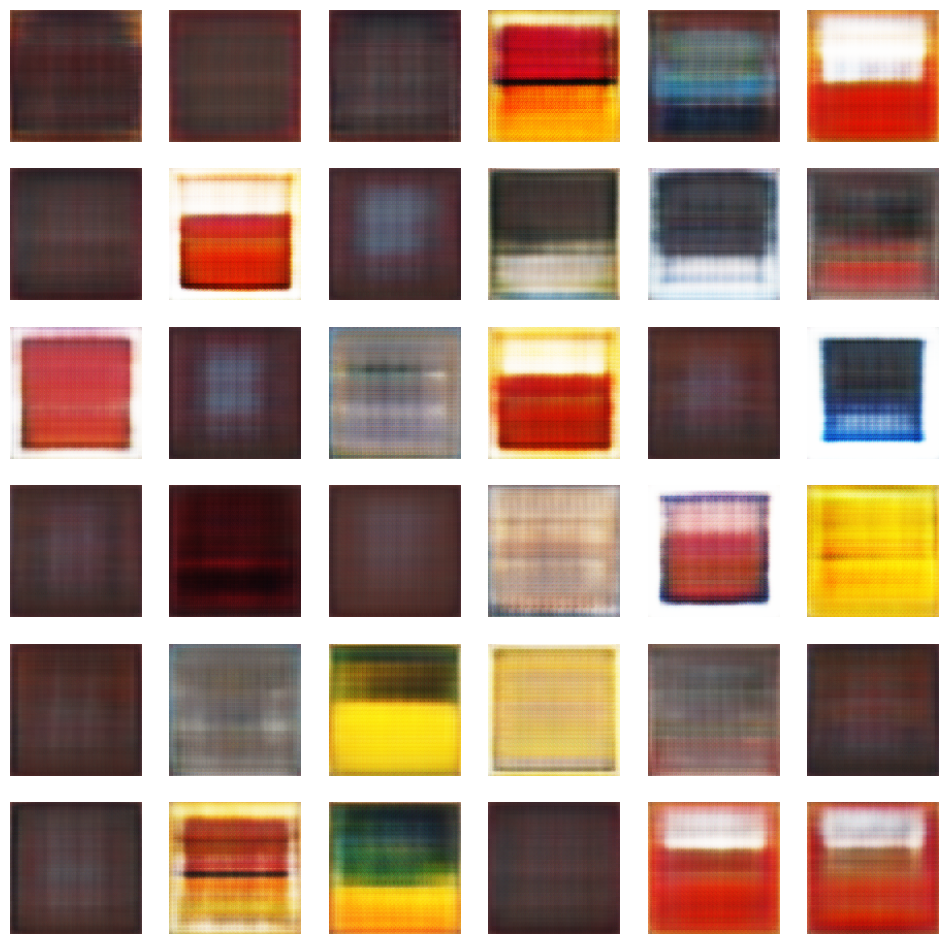

In [59]:
r, c=(6,6)
noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

display_rows(gen_imgs, cmap=None, r=6, c=6)

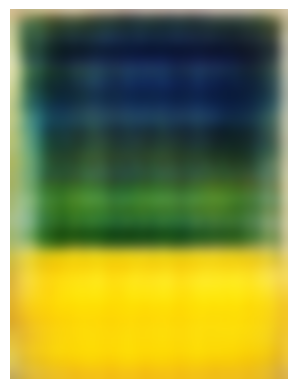

In [58]:
from PIL import Image, ImageFilter
from datetime import datetime

img = (gen_imgs[18] * 127.5) + 127.5
img

import matplotlib.pyplot as plt

pil_img = tf.keras.preprocessing.image.array_to_img(img)
pil_img = pil_img.resize((600, 800)).filter(ImageFilter.GaussianBlur(radius = 10))
plt.axis("off")
#plt.figure(figsize=(10,10)
plt.imshow(pil_img, interpolation="bicubic")
plt.savefig('./output/rothko_' + str(datetime.now()) + '.png')

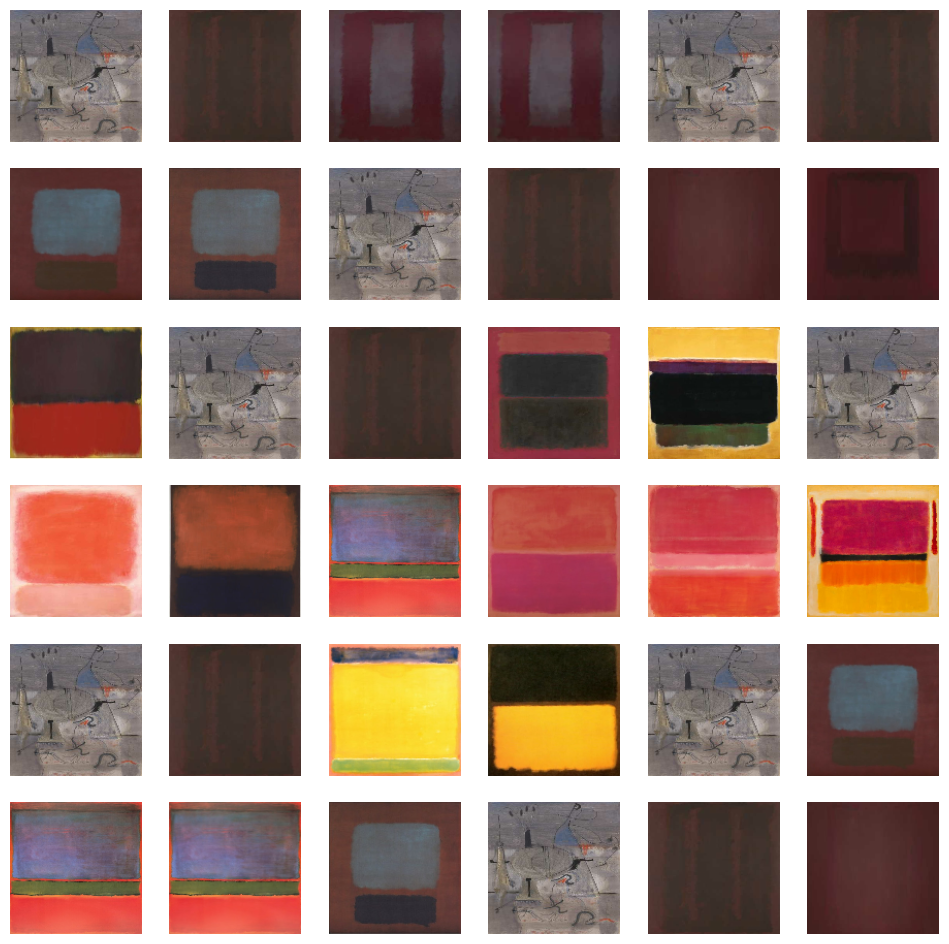

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

all_data = np.squeeze(np.array(list(train.as_numpy_iterator())))

closest = []

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                closest.append(c_img)
                c_diff = diff
        cnt += 1

display_rows(np.array(closest), cmap=None, r=6, c=6)